In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import datetime
from planar_ising_models import PlanarIsingModelGenerator, IsingInferenceAndSampling, PlanarIsingModel

np.random.seed(42)

In [2]:
graph_density = 0.8
interaction_values_std = 0.1

In [3]:
def compute_l2_error_between_empirical_and_theoretical_distribution(ising_model, sample_size):

    ising_inference_and_sampling = IsingInferenceAndSampling(ising_model)
    ising_inference_and_sampling.prepare_for_sampling()
    log_partition_function = ising_inference_and_sampling.compute_log_partition_function()
    configurations = ising_inference_and_sampling.sample_spin_configurations(sample_size)

    ising_model_doubled_interactions = PlanarIsingModel(ising_model.graph, 2*ising_model.interaction_values)
    ising_inference_doubled_interactions = IsingInferenceAndSampling(ising_model_doubled_interactions)
    log_partition_function_doubled_interactions = \
            ising_inference_doubled_interactions.compute_log_partition_function()

    l2_error_squared = np.exp(log_partition_function_doubled_interactions - 2*log_partition_function)

    configuration_statistics = {}
    
    for configuration in configurations:

        configuration_index = (configuration + 1).dot(2**np.arange(ising_model.graph.size))//2

        if configuration_index not in configuration_statistics:

            minus_energy = ising_model.get_minus_energy(configuration)
            minus_energy_doubled_interactions = \
                    ising_model_doubled_interactions.get_minus_energy(configuration)

            configuration_statistics[configuration_index] = (1, minus_energy, \
                    minus_energy_doubled_interactions)

        else:

            configuration_statistics[configuration_index] = \
                    (configuration_statistics[configuration_index][0] + 1,
                     configuration_statistics[configuration_index][1],
                     configuration_statistics[configuration_index][2])

    for frequency, minus_energy, minus_energy_doubled_interactions in configuration_statistics.values():
        l2_error_squared -= np.exp(minus_energy_doubled_interactions - 2*log_partition_function)
        l2_error_squared += (np.exp(minus_energy - log_partition_function) - frequency/sample_size)**2

    return np.sqrt(l2_error_squared)

In [4]:
def draw_empirical_distribution_l2_error():

    plt.figure(figsize=(9, 6))

    graph_sizes = [3, 10, 100, 300]
    log2_samples_sizes_per_graph_size = [np.arange(4, 21), np.arange(4, 16), np.arange(4, 11),
            np.arange(4, 10)]

    for graph_size, log2_sample_sizes in zip(graph_sizes, log2_samples_sizes_per_graph_size):

        ising_model = PlanarIsingModelGenerator.generate_random_model(graph_size, graph_density,
                interaction_values_std)

        l2_errors = []

        for log2_sample_size in log2_sample_sizes:

            sample_size = 2**log2_sample_size

            l2_error = compute_l2_error_between_empirical_and_theoretical_distribution(ising_model,
                    sample_size)

            l2_errors.append(l2_error)

        plt.plot(log2_sample_sizes, l2_errors, label='graph_size={}'.format(graph_size))

    plt.title('Empirical distribution L2-error')
    plt.xlabel('$\log_2$(sample size)')
    plt.ylabel('L2-error')
    plt.legend()
    plt.show()

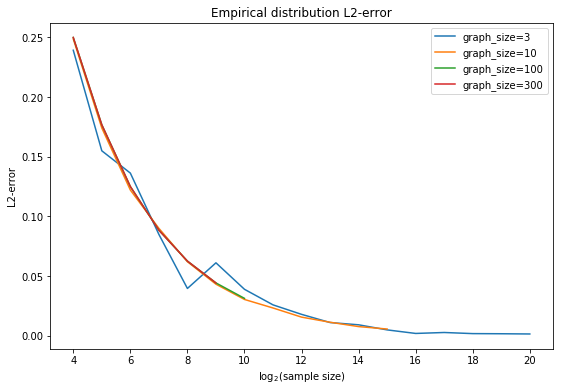

In [5]:
draw_empirical_distribution_l2_error()

In [6]:
def draw_execution_time():

    log2_graph_sizes = np.arange(2, 13)
    samples_count = 5

    log2_graph_sizes_per_sample = []
    preprocessing_times_per_samples = []
    sampling_times_per_sample = []

    for log2_graph_size in log2_graph_sizes:

        graph_size = 2**log2_graph_size

        for sample_index in range(samples_count):

            log2_graph_sizes_per_sample.append(log2_graph_size)

            ising_model = PlanarIsingModelGenerator.generate_random_model(graph_size, graph_density,
                    interaction_values_std)
            
            start_moment = datetime.datetime.now()
            ising_sampling = IsingInferenceAndSampling(ising_model)
            ising_sampling.prepare_for_sampling()
            preprocessing_time = (datetime.datetime.now() - start_moment).total_seconds()

            start_moment = datetime.datetime.now()
            ising_sampling.sample_spin_configurations(1)
            sampling_time = (datetime.datetime.now() - start_moment).total_seconds()

            preprocessing_times_per_samples.append(preprocessing_time)
            sampling_times_per_sample.append(sampling_time)

        print('Done with size {}'.format(graph_size))

    plt.figure(figsize=(9, 6))

    plt.scatter(log2_graph_sizes_per_sample, np.log2(preprocessing_times_per_samples), s=8, c='r',
            label='preprocessing')

    plt.scatter(log2_graph_sizes_per_sample, np.log2(sampling_times_per_sample), s=8, c='b',
            label='sampling')

    plt.plot(log2_graph_sizes, 3*log2_graph_sizes - 10, '--', label='$O(size^3)$')
    plt.plot(log2_graph_sizes, 1.5*log2_graph_sizes - 10, '--', label='$O(size^{1.5})$')

    plt.title('Execution time')
    plt.xlabel('$\log_2 (size)$')
    plt.ylabel('$\log_2 (sec.)$')
    plt.legend()
    plt.show()

Done with size 4
Done with size 8
Done with size 16
Done with size 32
Done with size 64
Done with size 128
Done with size 256
Done with size 512
Done with size 1024
Done with size 2048
Done with size 4096


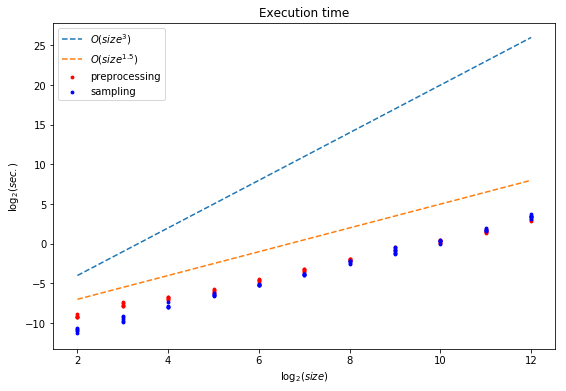

In [7]:
draw_execution_time()